**Outline**

The purpose of this script is to load concateated beta timecourses (for the BP and rest tasks), perform grand-averaging, and plot the results

**Import packages**

In [ ]:
import os
import mne 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

mne.set_log_level('ERROR')

**Define data directories and file names**

In [31]:
# Data path (from which we will read files)
data_path = os.path.join("/media/NAS/lbailey/PMBR_timecourse/output/1BP15")

# Define path to the trial timing data. There are duplicate rows in the csv which must be removed
trial_timings_fname = '/media/NAS/lbailey/PMBR_timecourse/output/trial_timings.csv'

# Define filenames for the concatenated arrays
bp_beta_fname = os.path.join(data_path, 'tfr_data_BP_beta_617_subjects.npy')
bp_allfreqs_fname = os.path.join(data_path, 'tfr_data_BP_617_subjects.npy')
rest_beta_fname = os.path.join(data_path, 'tfr_data_rest_beta_616_subjects.npy')

# Define filenames for info, freqs and times
bp_info_fname = os.path.join(data_path, 'bp-info.fif')
bp_freqs_fname = os.path.join(data_path, 'bp_freqs.npy')
bp_times_fname = os.path.join(data_path, 'bp_times.npy')

rest_info_fname = os.path.join(data_path, 'rest-info.fif')
rest_freqs_fname = os.path.join(data_path, 'rest_freqs.npy')
rest_times_fname = os.path.join(data_path, 'rest_times.npy')


**Load trial timings data**

In [3]:
# Load trial timings csv and remove duplicate rows
df_trial_timings = pd.read_csv(trial_timings_fname).drop_duplicates(ignore_index=True)

# Remove missing subjects
missing_subjects = ['CC620685', 'CC620444', 'CC120208', 'CC621118', 'CC410097', 'CC620557', 
                    'CC723197', 'CC221733', 'CC711244', 'CC720330', 'CC620567', 'CC122016', 
                    'CC512003', 'CC610462', 'CC510480']

df_trial_timings.drop(df_trial_timings[df_trial_timings['subject'].isin(missing_subjects)].index, inplace=True)

# Constrain trial timings data to long epochs (i.e., 1 s before and 15 s after)
df_long_trials = df_trial_timings[(df_trial_timings['t_since_prev_trial'] >= 1) 
                                        & (df_trial_timings['t_until_next_trial'] >= 15)]['t_since_prev_trial'].to_list()



**Load data for the BP and rest tasks**

In [144]:
# Get beta timecourse data for BP and rest
bp_data = np.load(bp_beta_fname)
rest_data = np.load(rest_beta_fname)

# Also load the tfr data (containing all frequencies) for the BP task 
bp_data_allfreqs = np.load(bp_allfreqs_fname)

# Load in info, times, and freqs for the BP data
info_bp = mne.io.read_info(bp_info_fname)
times_bp = np.load(bp_times_fname,  allow_pickle=True).squeeze()
freqs_bp = np.load(bp_freqs_fname,  allow_pickle=True).squeeze()

**Compute grand-average TFRs for the BP data**

In [36]:
# Average the tfr data across epochs (first axis)
tfr_data = np.mean(bp_data_allfreqs, axis=0)

# Plug into an averageTFR object
tfr_gavg = mne.time_frequency.AverageTFR(info_bp, tfr_data, times_bp, freqs_bp)


**Compute descriptive stats for beta timecourses (gavg and SD's)**

In [37]:
# Compute grand averages
bp_gavg = np.mean(bp_data, axis=0)
rest_gavg = np.mean(rest_data, axis=0)

# Get standard deviations
bp_std = np.std(bp_data, axis=0)
rest_std = np.std(rest_data, axis=0)

# And standard errors
bp_sem = bp_std / np.sqrt(bp_data.shape[0])
rest_sem = rest_std / np.sqrt(rest_data.shape[0])

**Make a figure for the BP data, with time courses and raster plots for each channel**


In [132]:
# Set some parameters for plotting

# Define channels
channels = [0,1]

# Use matplotlib's default colours for each channel, to maintain consistency with other plots
colours = ['#1f77b4', '#ff7f0e'] 

# Define colour range for TFR plots
colRange = .3

# Define other parameters for the tfrplots
tfr_baseline_period = (10, 15)
tfr_baseline_mode = 'logratio'

tfr_fmin = 8
tfr_vmin, tfr_vmax = -colRange, colRange
tfr_tmax = 15

Text(0, 0.5, 'Power change from \nbaseline (log ratio)')

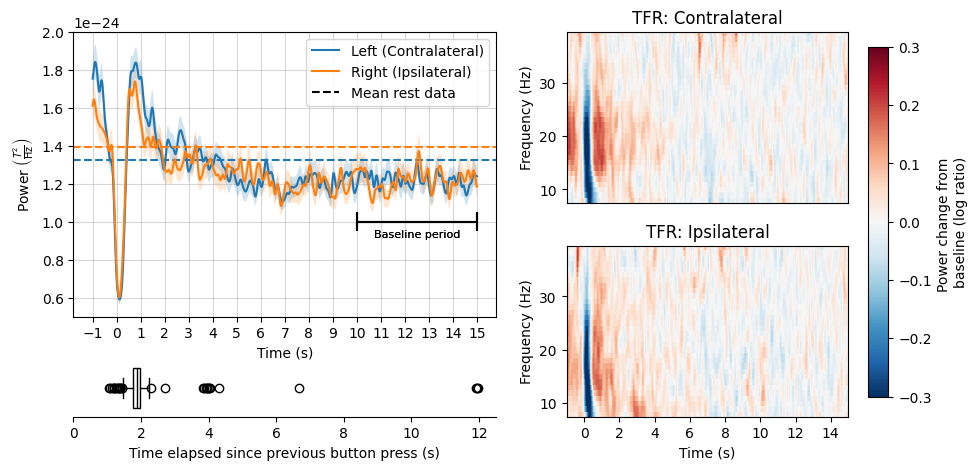

In [146]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# Main GridSpec with two columns
outer_gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])

# Nested GridSpec for the first column with height ratios [2, 1]
gs_col1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[0], height_ratios=[1, 0.2])

# Nested GridSpec for the second column with height ratios [1, 1]
gs_col2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[1], height_ratios=[1, 1])

# Add subplots to the nested GridSpecs
ax1 = fig.add_subplot(gs_col1[0])
ax2 = fig.add_subplot(gs_col1[1])
ax3 = fig.add_subplot(gs_col2[0])
ax4 = fig.add_subplot(gs_col2[1])

# Loop through channels
for ch in channels:

    # Define labels for each channel
    if ch == 0:
        channel_lab = 'Left (Contralateral)'
    elif ch == 1:
        channel_lab = 'Right (Ipsilateral)'

    ############################################################################################################
    # Axis 1 (top left subplot): grand average beta timecourses
    ############################################################################################################
    ax1.plot(times_bp, bp_gavg[ch, :], label = channel_lab, color = colours[ch])
    ax1.fill_between(times_bp, bp_gavg[ch, :] - bp_sem[ch, :], bp_gavg[ch, :] + bp_sem[ch, :], alpha=0.2)

    # Plot mean power in the rest data
    ax1.axhline(y = np.mean(rest_gavg[ch,:]), linestyle='--', color = colours[ch], label = None)

    # Set axis parameters for ax1
    ax1.set_xticks(np.arange(-1, 16, 1))
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel(r'Power $\left(\frac{T^2}{\text{Hz}}\right)$')   # Or use ('Power ($T^2$ / Hz)')  to avoid the fraction

    # Add grid and legend, including a dashed line for rest data
    ax1.grid(alpha=0.5)

    # # Add a dashed line to the legend to represent rest data
    handles, labels = ax1.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], color='k', linestyle='--'))
    labels.append('Mean rest data')
    ax1.legend(handles, labels)

    # Add a horizontal line between x = 10 and x = 15 to represent the baseline period
    ax1.hlines(y = 1e-24, xmin=10 , xmax = 15, color= 'k', axes=ax1)

    # Add vertical ticks and a label
    ax1.vlines(x = 10, ymin=0.95e-24, ymax=1.05e-24, color= 'k')
    ax1.vlines(x = 15, ymin=0.95e-24, ymax=1.05e-24, color= 'k')
    ax1.text(12.5, 0.92e-24, 'Baseline period', fontsize=8, horizontalalignment='center')
    
############################################################################################################
# Axis 2 (bottom left subplot): boxplot of precding times on long trials
############################################################################################################
ax2.boxplot(df_long_trials, vert=False, patch_artist=True, widths=0.7, boxprops=dict(facecolor='white'), medianprops=dict(color='k'))

# Remove boxplot borders and set x axis label
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlabel('Time elapsed since previous button press (s)')

# Set x axis limits and remove y axis ticks
# ax2.set_xlim([0, 15])
ax2.set_xticks(np.arange(0, 13, 2))
ax2.set_yticks([])

############################################################################################################
# Axis 3 (top right subplot): TFR for contralateral channel
############################################################################################################

ax3.set_title('TFR: Contralateral')

# Plot the TFR
tfr_gavg.copy().pick('MEG0211').apply_baseline(mode=tfr_baseline_mode, baseline=tfr_baseline_period
                                            ).plot(fmin=8, vmin=tfr_vmin, vmax=tfr_vmax, tmax=tfr_tmax,
                                                    colorbar = False, show=False, axes=ax3)

# Hide the x axis and label for this plot (they are shared with the plot below)
ax3.set_xlabel('')
ax3.set_xticks([])

############################################################################################################
# Axis 4 (top right subplot): TFR for ipsilateral channel
############################################################################################################
ax4.set_title('TFR: Ipsilateral')

tfr_gavg.copy().pick('MEG1311').apply_baseline(mode=tfr_baseline_mode, baseline=tfr_baseline_period
                                            ).plot(fmin=8, vmin=tfr_vmin, vmax=tfr_vmax, tmax=tfr_tmax,
                                                    colorbar = False, show=False, axes=ax4)

# Set x axis parameters 
ax4.set_xticks(np.arange(0, 16, 2))

############################################################################################################
# Adjustments to main figure
############################################################################################################

# Adjust layout
plt.subplots_adjust(hspace=0.25)

# Add a colorbar to the right of the plot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ax3.images[0], cax=cbar_ax)
cbar_ax.set_ylabel('Power change from \nbaseline (log ratio)')

